In [1]:
%pylab inline
import seaborn as sns
import ipywidgets as widgets
sns.set_context('talk')
from skimage.measure import find_contours
from scipy.interpolate import interp1d
from scipy import fftpack

Populating the interactive namespace from numpy and matplotlib


(-0.5, 149.5, 99.5, -0.5)

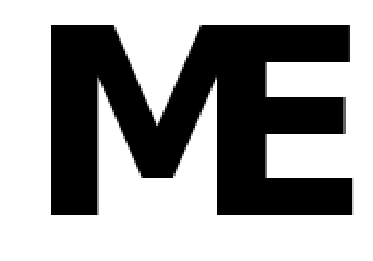

In [2]:
img = imread("ME.png")
imshow(img)
axis('off')

## Kontur als periodische Funktuon z(t)

In [3]:
contour = find_contours(img[:,:,0], .5)[0]
z_coef = contour[:,1] + (100-contour[:,0]) * 1j
z = interp1d(linspace(0,1,z_coef.shape[0]), z_coef)

In [4]:
@widgets.interact(t=(0,3,.001))
def plot_contour(t=0):
    plot(z_coef.real, z_coef.imag)
    x = z(t%1)
    plot(x.real, x.imag, 'o')
    text(x.real+3, x.imag-2, "t={:.3f}".format(t))
    sns.despine()
    show()

Widget Javascript not detected.  It may not be installed or enabled properly.


## FFT der Kontur

In [5]:
c_coef = fftpack.fftshift(fftpack.fft(z(linspace(0,1,501)))) / 501
n0 = 250

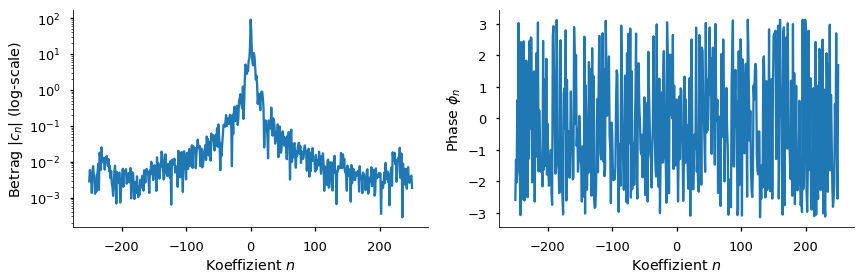

In [6]:
figure(figsize=(14,4))

subplot(121)
semilogy(arange(len(c_coef))-n0, abs(c_coef))
xlabel("Koeffizient $n$")
ylabel("Betrag $|c_n|$ (log-scale)")
sns.despine()

subplot(122)
plot(arange(len(c_coef))-n0, np.angle(c_coef))
xlabel("Koeffizient $n$")
ylabel("Phase $\\phi_n$")
sns.despine()

# Rekonstruktion

$$z'(t) = \sum_{n=-N}^N c_n \exp(2\pi{}j\cdot nt)\quad t \in [0,1)$$

In [7]:
def reconstruct_z(t, coef=c_coef):
    n0 = coef.shape[0]//2
    return sum(c * exp(2j*pi * (n-n0)*t) for n,c in enumerate(coef))

In [8]:
@widgets.interact(N=(1,100),skip=(0,20))
def approx_contour(N=100,skip=0):
    cc = np.r_[c_coef[n0-N-skip:n0-skip], c_coef[n0+skip:n0+N+skip]]
    zz = reconstruct_z(linspace(0,1,c_coef.shape[0]), cc)
    plot(zz.real, zz.imag)
    sns.despine()
    show()

Widget Javascript not detected.  It may not be installed or enabled properly.


## Zufällige Phase

$$c_i := |c_i| \exp(φ'\,2\pi\,j)$$

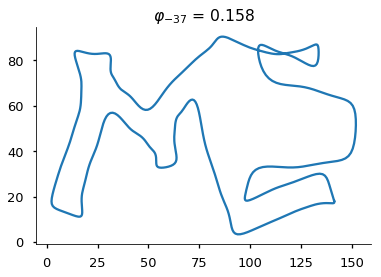

In [60]:
# Zufällige Phase
cc = c_coef[n0-42:n0+42].copy()
i = randint(len(cc))-42
cc[i] = abs(cc[42+i]) * exp(rand()*2j*pi)
title(r"$\varphi_{{{}}}$ = {:.3f}".format(i, np.angle(cc[i])))
zz = reconstruct_z(linspace(0,1,c_coef.shape[0]), cc)
plot(zz.real, zz.imag)
sns.despine()

## Translationsinvarianz

$$c_0 := 0$$

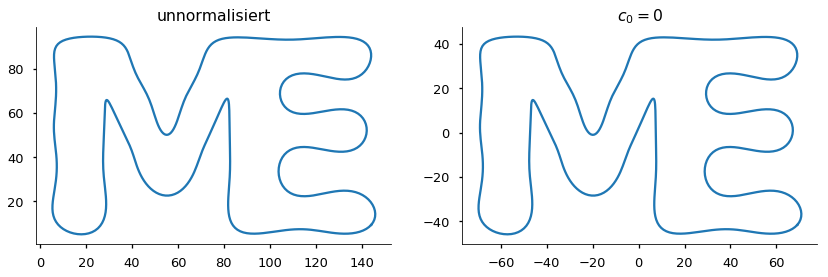

In [10]:
cc = c_coef[n0-23:n0+23].copy()

figure(figsize=(14,4))
subplot(121)
title(r"unnormalisiert")
zz = reconstruct_z(linspace(0,1,c_coef.shape[0]), cc)
plot(zz.real, zz.imag)
sns.despine()

subplot(122)
title(r"$c_0 = 0$")
cc[len(cc)//2] = 0
zz = reconstruct_z(linspace(0,1,c_coef.shape[0]), cc)
plot(zz.real, zz.imag)
sns.despine()
show()

## Skalierungsinvarianz

$$c_n := \frac{c_n}{c_m}\quad \text{für festes }m$$

In [11]:
@widgets.interact(a=(-5,5,.01), m=(-23,23))
def approx_contour(a=1, m=1):
    zz = a * z(linspace(0,1,501))
    cc = fftpack.fftshift(fftpack.fft(zz)) / 501
    cc = cc[n0-23:n0+23]
    
    figure(figsize=(14,4))
    subplot(121)
    title(r"unnormalisiert")
    zz = reconstruct_z(linspace(0,1,c_coef.shape[0]), cc)
    plot(zz.real, zz.imag)
    sns.despine()
    
    subplot(122)
    title(r"$c_n = c_n / |c_{{{}}}|$".format(m))
    cc /= abs(cc[m])
    zz = reconstruct_z(linspace(0,1,c_coef.shape[0]), cc)
    plot(zz.real, zz.imag)
    sns.despine()
    show()

Widget Javascript not detected.  It may not be installed or enabled properly.


## Rotationsinvarianz

$$c_n := c_n \exp(-j \varphi_m)\quad \text{für festes } m$$

In [23]:
@widgets.interact(phi=(-3.14,3.14,.01), m=(-23,23))
def approx_contour(phi=0, m=16):
    zz = z(linspace(0,1,501)) * exp(phi*1j)
    cc = fftpack.fftshift(fftpack.fft(zz)) / 501
    cc = cc[n0-23:n0+23]
    
    figure(figsize=(14,4))
    subplot(121)
    title(r"unnormalisiert")
    zz = reconstruct_z(linspace(0,1,c_coef.shape[0]), cc)
    plot(zz.real, zz.imag)
    sns.despine()
    
    subplot(122)
    title(r"$c_n = c_n \cdot \exp(-j\,\varphi_{{{}}})$".format(m))

    cc *= exp(-1j * np.angle(cc[m]))
    zz = reconstruct_z(linspace(0,1,c_coef.shape[0]), cc)
    plot(zz.real, zz.imag)
    sns.despine()
    show()

Widget Javascript not detected.  It may not be installed or enabled properly.
